In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely

In [2]:
places = pd.read_csv('../data/place_df.csv')

In [3]:
import cartopy.io.img_tiles as cimgt

def cat_data(ndf, lots, do_na=True):
    # Set the evidence categories
    ndf["evidence_cat"] = np.nan
    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']==0),"evidence_cat"
    ] = 1

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>0),"evidence_cat"
    ] = 2

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 3

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']==0),"evidence_cat"
    ] = 4

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>0),"evidence_cat"
    ] = 5

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 6
    
    colors = ["#abdda4","#3288bd", "#5e4fa2","#fee08b","#d53e4f","#9e0142"]
    cmap = mpl.colors.ListedColormap(colors)

    do_na = True
    if do_na:
        cmap = mpl.colors.ListedColormap(colors+["white","#e0e0e0","#878787"])
        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']==0),"evidence_cat"
        ] = 7

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>0),"evidence_cat"
        ] = 8

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>lots),"evidence_cat"
        ] = 9
        
    return ndf, cmap

def draw_basemap(figsize, region):
    plt.figure(dpi=150, figsize=figsize)

    if region is not None:
        ax = plt.axes(projection=ccrs.EqualEarth(central_longitude=region["central_longitude"]))
        ax.set_extent(region["extent"])   
    else:
        ax = plt.axes(projection=ccrs.EqualEarth())

    #ax.add_image(stamen_terrain, 3)

    ax.coastlines(lw=0.1)
    return ax

def plot_gridcells(ndf, var, degrees, lots=1, region=None):
    
    ndf, cmap = cat_data(ndf, lots) 
    
    

    
    if region is not None:
        rname = region["name"]
        figsize = region["figsize"]
        cbar_orientation = region["cbar_orientation"]
        cbar_fraction = region["cbar_fraction"]
    else:
        rname = "global"
        figsize = (8,5)
        cbar_orientation = "horizontal"
        cbar_fraction = 0.1
           
    
    ndf.loc[ndf['LON']>180,"LON"]-=360

    
    ax = draw_basemap(figsize, region)

    n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    vm = round(n.max()/10*10)
    n[n==0] = np.nan

    
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
        cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
        transform=ccrs.PlateCarree(),
        #alpha=0.5
    )
    
    cbar = plt.colorbar(mesh, orientation=cbar_orientation, fraction=cbar_fraction, pad=0.05)    
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/gridcells_studies_{var}_{str(degrees).replace('.','_')}_{rname}.png")
    plt.close()

    ###################################
    ## DA only
        
    ax = draw_basemap(figsize, region)
    
    bn = np.zeros((len(ndf.LAT.unique()), len(ndf.LON.unique())))
    bn+=1
    
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        bn,
        cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
        transform=ccrs.PlateCarree(),
    )
    
    n = np.array(ndf.da_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    mesh = ax.pcolormesh(
        ndf.LON.unique(),
        ndf.LAT.unique(),
        n,
        cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
        transform=ccrs.PlateCarree(),
    )
    cbar = plt.colorbar(mesh, orientation=cbar_orientation, fraction=cbar_fraction, pad=0.05)    
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/gridcells_da_{var}_{str(degrees).replace('.','_')}_{rname}.png")
    plt.close()
    
    #######################################
    ## Combination nstudies DA
    
    ax = draw_basemap(figsize, region)

    n = np.array(ndf.evidence_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

    ax.coastlines(lw=0.2)
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        cmap = cmap,
        transform=ccrs.PlateCarree(),
    )
    cbar = plt.colorbar(mesh, orientation=cbar_orientation, fraction=cbar_fraction, pad=0.05)
    cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

    cbar.set_ticklabels([
        "D&A trend\n 0 impacts",
        f"D&A trend\n <{lots} impacts",
        f"D&A trend\n >{lots} impacts",
        "no D&A trend\n 0 impacts",
        f"no D&A trend\n <{lots} impacts",
        f"no D&A trend\n >{lots} impacts",
        "no D&A data\n 0 impacts",
        f"no D&A data\n <{lots} impacts",
        f"no D&A data\n >{lots} impacts"
    ])
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/gridcells_da_studies_{var}_{str(degrees).replace('.','_')}_{rname}.png", bbox_inches="tight")
    plt.close()
    
regions = [
    {"name": "Africa", "extent": [-24,55,-32,32], "figsize": (4,6), "cbar_orientation": "vertical", "cbar_fraction": 0.05, "central_longitude": 15},
    {"name": "Europe", "extent": [-24,40, 32,70], "figsize": (5.5,4), "cbar_orientation": "horizontal", "cbar_fraction": 0.1, "central_longitude": 15},
    {"name": "South America", "extent": [-87,-30, -60,20], "figsize": (7,5), "cbar_orientation": "vertical", "cbar_fraction": 0.05, "central_longitude": -75},
    {"name": "North America", "extent": [-150,-60, 5,70], "figsize": (7,7), "cbar_orientation": "horizontal", "cbar_fraction": 0.08, "central_longitude": -90},
    {"name": "Asia", "extent": [35,170, -5,65], "figsize": (7,5), "cbar_orientation": "horizontal", "cbar_fraction": 0.08, "central_longitude": 120},
    {"name": "Oceania", "extent": [105, 180, -44,0], "figsize": (5,6), "cbar_orientation": "vertical", "cbar_fraction": 0.04, "central_longitude":150}
]
    
for degrees in [2.5]:
    ndf = pd.read_csv(f'../data/gridcell_studies_6 - Precipitation - upper_pred_{degrees}.csv')
    
    plot_gridcells(ndf, "precip", degrees, lots=5)
    
    #for region in regions:
    #    plot_gridcells(ndf, "precip", degrees, lots=5, region=region)

In [4]:
for degrees in [2.5]:
    ndf = pd.read_csv(f'../data/gridcell_studies_6 - Temperature - upper_pred_{degrees}.csv')
    
    plot_gridcells(ndf, "temp", degrees, lots=5)
    
    for region in regions:
        plot_gridcells(ndf, "temp", degrees, lots=5, region=region)

In [5]:
tdf = pd.read_csv(f'../data/gridcell_studies_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/gridcell_studies_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

df = pd.concat([tdf,pdf])

df, cmap = cat_data(df, 5, do_na=True)

df.head()

,LAT,LON,n_studies,LAT_25,LON_25,da_cat,index,n_study_prop,da_var,evidence_cat
0,-88.75,181.25,0.0,-87.5,182.5,NaN,0,0.0,Temperature,7.0
1,-88.75,183.75,0.0,-87.5,182.5,NaN,1,0.0,Temperature,7.0
2,-88.75,186.25,0.0,-87.5,187.5,NaN,4,0.0,Temperature,7.0
3,-88.75,188.75,0.0,-87.5,187.5,NaN,5,0.0,Temperature,7.0
4,-88.75,191.25,0.0,-87.5,192.5,NaN,8,0.0,Temperature,7.0


In [6]:
bounds = np.array([0,1,5,10,50,100,500,1000,5000])

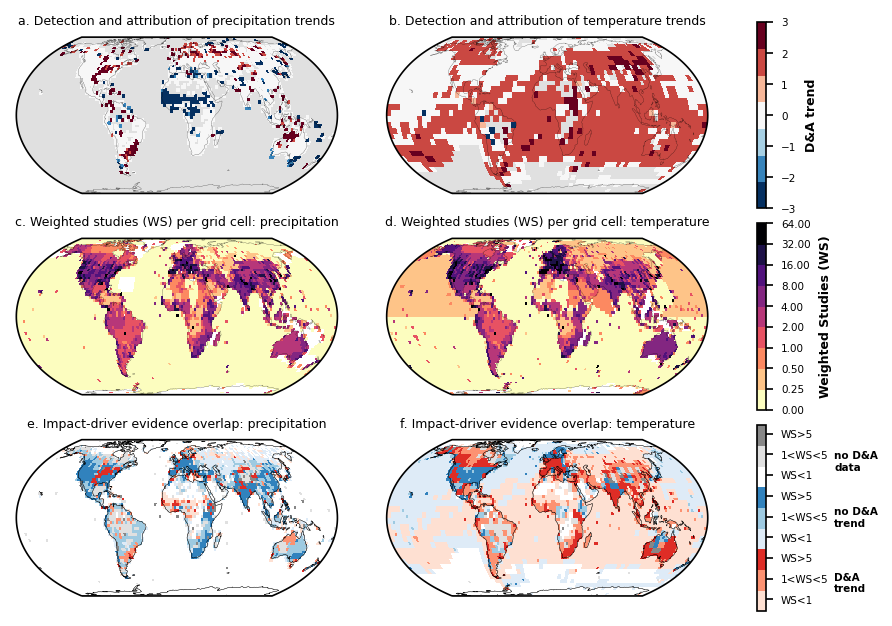

In [44]:
bounds = np.array([0,0.25,0.5,1,2,4,8,16,32,64])

def cat_data(ndf, lots, do_na=True):
    # Set the evidence categories
    ndf["evidence_cat"] = np.nan
    little = 1
    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']<little),"evidence_cat"
    ] = 1

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>little),"evidence_cat"
    ] = 2

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 3

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']<little),"evidence_cat"
    ] = 4

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>little),"evidence_cat"
    ] = 5

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 6
    
    colors = ["#abdda4","#3288bd", "#5e4fa2","#fee08b","#d53e4f","#9e0142"]
    colors = ['#fee0d2','#fc9272','#de2d26'] + ['#deebf7','#9ecae1','#3182bd']
    cmap = mpl.colors.ListedColormap(colors)

    do_na = True
    if do_na:
        cmap = mpl.colors.ListedColormap(colors+["white","#e0e0e0","#878787"])
        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']<little),"evidence_cat"
        ] = 7

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>little),"evidence_cat"
        ] = 8

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>lots),"evidence_cat"
        ] = 9
        
    return ndf, cmap

lots = 5
little = 1

df, cmap = cat_data(df, lots, do_na=True)

gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.3], hspace=0.08)

fig = plt.figure(figsize=(7.2,5.2), dpi=150)

vm = round(df.n_studies.max()/10*10)


axs = []

for i, (name, ndf) in enumerate(df.groupby('da_var')):
    
    ndf.loc[ndf['LON']>180,"LON"]-=360
    
    ax = plt.subplot(gs[0, i], projection=ccrs.EqualEarth())
    
    axs.append(ax)
    
    ax.coastlines(lw=0.1)
    
    bn = np.zeros((len(ndf.LAT.unique()), len(ndf.LON.unique())))
    bn+=1
    
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        bn,
        cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
        transform=ccrs.PlateCarree(),
    )
    
    n = np.array(ndf.da_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    mesh = ax.pcolormesh(
        ndf.LON.unique(),
        ndf.LAT.unique(),
        n,
        cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
        transform=ccrs.PlateCarree(),
    )
    if i==1:
        cax = plt.subplot(gs[0,2])
        cbar = plt.colorbar(mesh, ax=cax, pad=-.5, fraction=1)    
        
        cax.axis('off')
        cbar.ax.tick_params(labelsize=5)
        cbar.ax.set_ylabel("D&A trend", fontsize=6, fontweight="bold")
    
    
    ###############
    
    ax = plt.subplot(gs[1, i], projection=ccrs.EqualEarth())
    axs.append(ax)
    ax.coastlines(lw=0.1)   
    
    n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    #vm = round(n.max()/10*10)
    n[n==0] = np.nan

    
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        #norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
        norm = mpl.colors.BoundaryNorm(bounds,256),
        #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
        #cmap = "YlOrBr",
        cmap = "magma_r",
        transform=ccrs.PlateCarree(),
        #alpha=0.5
    )
    if i==1:
        cax = plt.subplot(gs[1,2])
        cbar = plt.colorbar(mesh, ax=cax, pad=-.5, fraction=1)    
        
        cax.axis('off')
        cbar.ax.tick_params(labelsize=5)
        cbar.ax.set_ylabel("Weighted Studies (WS)", fontsize=6, fontweight="bold")
    
    #######################################################
    ### 
    
    ax = plt.subplot(gs[2, i], projection=ccrs.EqualEarth())
    ax.coastlines(lw=0.1)   
    axs.append(ax)
    
    n = np.array(ndf.evidence_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

    ax.coastlines(lw=0.2)
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        cmap = cmap,
        transform=ccrs.PlateCarree(),
    )
    if i==1:
        cax = plt.subplot(gs[2,2])
        cbar = plt.colorbar(mesh, ax=cax, pad=-.5, fraction=1)    
        
        cax.axis('off')
        cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

        cbar.set_ticklabels([
            f"WS<{little}",
            f"{little}<WS<{lots}",
            f"WS>{lots}"
        ]*3)
        cbar.ax.tick_params(labelsize=5)
        
        cax.text(1.6,0.15, "D&A\ntrend", fontsize=5,ha="left", va="center", fontweight="bold")        
        cax.text(1.6,0.5, "no D&A\ntrend", fontsize=5,ha="left", va="center", fontweight="bold")
        cax.text(1.6,0.8, "no D&A\ndata", fontsize=5,ha="left", va="center", fontweight="bold")
        
        
axs[0].set_title("a. Detection and attribution of precipitation trends", fontsize=6)
axs[3].set_title("b. Detection and attribution of temperature trends", fontsize=6)
axs[1].set_title("c. Weighted studies (WS) per grid cell: precipitation", fontsize=6)
axs[4].set_title("d. Weighted studies (WS) per grid cell: temperature", fontsize=6)
axs[2].set_title("e. Impact-driver evidence overlap: precipitation", fontsize=6)
axs[5].set_title("f. Impact-driver evidence overlap: temperature", fontsize=6)
        
plt.savefig(f"../figures/figure_2.png", dpi=500, bbox_inches="tight")
#plt.savefig(f"../figures/figure_2.svg")
plt.savefig(f"../figures/figure_2.pdf", bbox_inches="tight")

Text(0, 0.5, 'Weighted Studies (WS)')

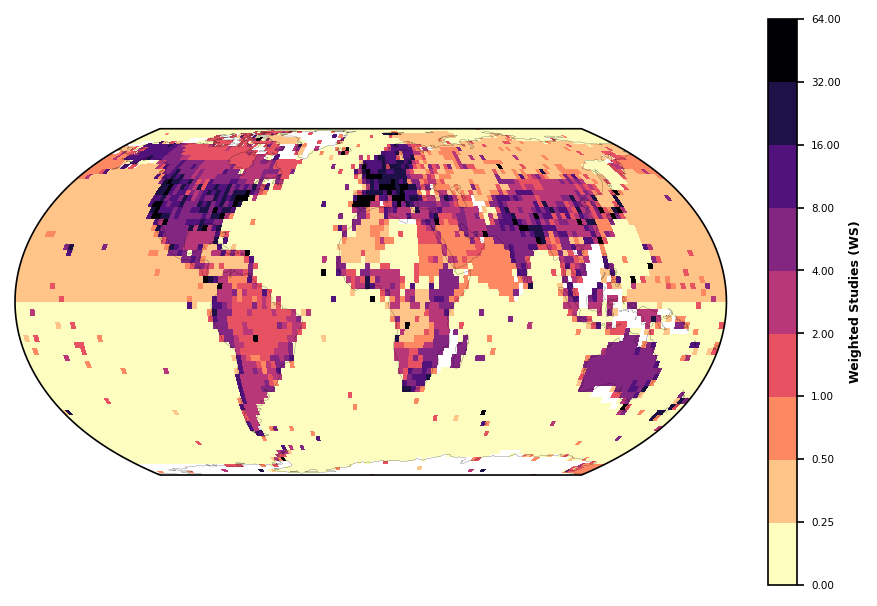

In [36]:
fig = plt.figure(figsize=(7.2,5), dpi=150)

bounds = np.array([0,0.25,0.5,1,2,4,8,16,32,64])


ax = plt.subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.1)   

n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
#vm = round(n.max()/10*10)
n[n==0] = np.nan


mesh = ax.pcolormesh(
    ndf.LON.unique(),#-degrees*0.5,
    ndf.LAT.unique(),#-degrees*0.5,
    n,
    #norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    transform=ccrs.PlateCarree(),
    #alpha=0.5
)

cbar = plt.colorbar(mesh, fraction=.1)    

cax.axis('off')
cbar.ax.tick_params(labelsize=5)
cbar.ax.set_ylabel("Weighted Studies (WS)", fontsize=6, fontweight="bold")

# Example Sudan

In [4]:
shp_ndf_df = pd.read_csv('../data/country_ndf_correspondence.csv')

In [24]:
ndf = pd.read_csv(f'../data/gridcell_studies_6 - Precipitation - upper_pred_2.5.csv')

ndf["Country"] = np.nan
ndf["na"] = np.where(pd.isna(ndf["da_cat"]),1,np.nan)
ndf_ids = shp_ndf_df.loc[shp_ndf_df["shpfile_id"]==52, "ndf_id"]
ndf.loc[ndf_ids,"Country"]=ndf.loc[ndf_ids,"n_study_prop"]
ndf.loc[ndf_ids,"cmask"]=np.nan
n = np.array(ndf.Country).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

vm = np.nanmax(vm)

cn = np.array(ndf.na).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

bn = np.array(ndf.cmask).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

n[~np.isnan(n)]

array([0.14814815, 0.16194125, 0.16194125, 0.16194125, 0.16194125,
       0.14814815, 0.16194125, 0.16194125, 0.16194125, 0.66194125,
       0.16194125, 0.14814815, 0.16194125, 0.16194125, 0.16194125,
       2.12563173, 1.66194125, 0.16194125, 0.16194125, 0.16194125,
       0.16194125, 0.16194125, 0.16194125, 0.16194125, 0.16194125,
       0.16194125, 0.16194125])

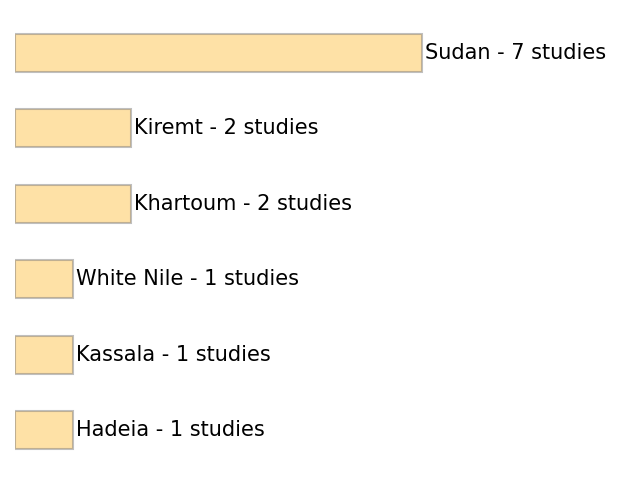

In [6]:
fig, ax = plt.subplots(dpi=150, figsize=(4,4))

df_ndf = pd.read_csv('../data/study_gridcell_6 - Precipitation - upper_pred_2.5.csv')
doc_ids = df_ndf.loc[df_ndf["ndf_id"].isin(ndf_ids),"doc_id"]

splaces = places[(places["doc_id"].isin(doc_ids)) & (places["country_predicted"]=="SDN")].groupby('word').size().sort_values()

splaces.plot.barh(color="#fec44f", alpha=0.5, edgecolor="grey")

for i, c in enumerate(splaces):
    ax.text(c+0.05, i, f"{splaces.index[i]} - {c} studies", va="center")
    
ax.set_xlim(0,c+1)
plt.axis('off')

plt.savefig("../plots/maps/sudan_precipitation_study_places.png", bbox_inches="tight")


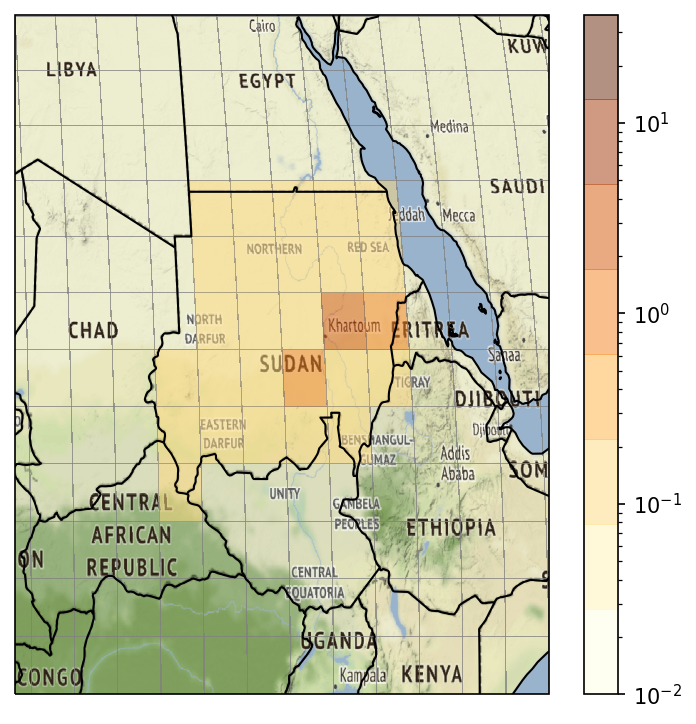

In [7]:
import cartopy.io.img_tiles as cimgt

stamen_terrain = cimgt.Stamen('terrain')

plt.figure(dpi=150, figsize=(6,6))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.coastlines(lw=1)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS, lw=1)
#ax.set_extent([0,30,50,80])

ax.set_extent([15,45,0,30])

ax.add_image(stamen_terrain, 5)

mesh = ax.pcolormesh(
    ndf.LON.unique(),#-degrees*0.5,
    ndf.LAT.unique(),#-degrees*0.5,
    n,
    transform=ccrs.PlateCarree(),
    edgecolor="grey",
    norm = mpl.colors.LogNorm(vmin=0.01, vmax=vm),
    cmap=plt.cm.get_cmap('YlOrBr',8), 
    lw=0.1,
    alpha=0.5
)

cbar = plt.colorbar(mesh)

plt.savefig("../plots/maps/sudan_precipitation_studies.png", bbox_inches="tight")


(10368, 8)


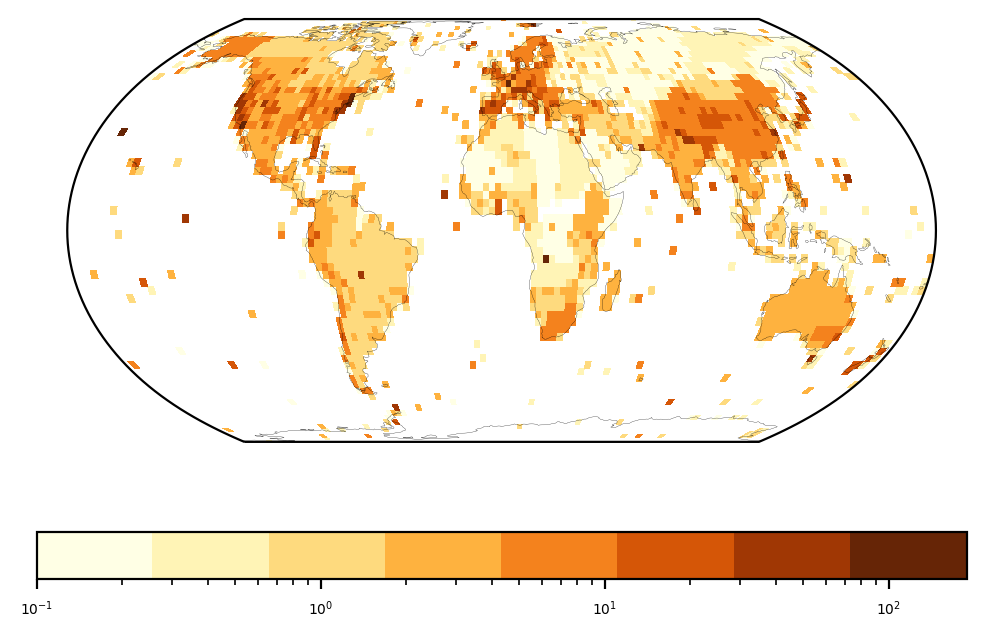

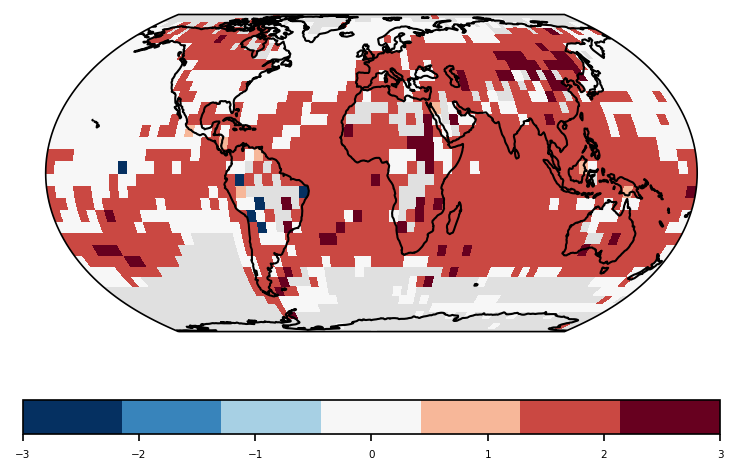

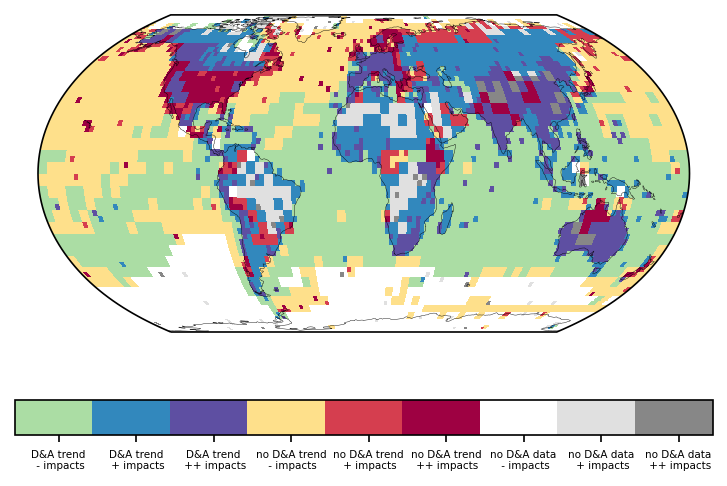

In [20]:
for degrees in [2.5]:
    ndf = pd.read_csv(f'../data/gridcell_studies_6 - Temperature - upper_pred_{degrees}.csv')
    
    print(ndf.shape)

    plt.figure(dpi=200)
    
    ndf.loc[ndf['LON']>180,"LON"]-=360

    ax = plt.axes(projection=ccrs.EqualEarth())

    n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    vm = n.max()
    n[n==0] = np.nan

    ax.coastlines(lw=0.1)
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
        cmap=plt.cm.get_cmap('YlOrBr',8), 
        transform=ccrs.PlateCarree()
    )
    cbar = plt.colorbar(mesh, orientation="horizontal")
    
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/temp_studies_{degrees}.png")
    plt.close()
    
    
    ndf["evidence_cat"] = np.nan
    
    lots = ndf.n_study_prop.quantile(.9)

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']==0),"evidence_cat"
    ] = 1

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>0),"evidence_cat"
    ] = 2

    ndf.loc[
        (abs(ndf['da_cat'])>1) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 3

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']==0),"evidence_cat"
    ] = 4

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>0),"evidence_cat"
    ] = 5

    ndf.loc[
        (abs(ndf['da_cat'])==0) & (ndf['n_study_prop']>lots),"evidence_cat"
    ] = 6
    
    colors = ["#abdda4","#3288bd", "#5e4fa2","#fee08b","#d53e4f","#9e0142"]

    cmap = mpl.colors.ListedColormap(colors)

    do_na = True
    if do_na:
        cmap = mpl.colors.ListedColormap(colors+["white","#e0e0e0","#878787"])
        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']==0),"evidence_cat"
        ] = 7

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>0),"evidence_cat"
        ] = 8

        ndf.loc[
            (pd.isna(ndf['da_cat'])) & (ndf['n_study_prop']>lots),"evidence_cat"
        ] = 9

        
    ## DA only
        
    plt.figure(dpi=150)
    
    ax = plt.axes(projection=ccrs.EqualEarth())
    
    bn = np.zeros((len(ndf.LAT.unique()), len(ndf.LON.unique())))
    bn+=1
    
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        bn,
        cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
        transform=ccrs.PlateCarree(),
    )
    
    n = np.array(ndf.da_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))
    ax.coastlines()
    mesh = ax.pcolormesh(
        ndf.LON.unique(),
        ndf.LAT.unique(),
        n,
        cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
        transform=ccrs.PlateCarree(),
    )
    cbar = plt.colorbar(mesh, orientation="horizontal")
    
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/d_a_temp_{degrees}.png")
    
    
    ## Combination
    
    plt.figure(dpi=150)

    ax = plt.axes(projection=ccrs.EqualEarth())

    n = np.array(ndf.evidence_cat).reshape(len(ndf.LAT.unique()),len(ndf.LON.unique()))

    ax.coastlines(lw=0.2)
    mesh = ax.pcolormesh(
        ndf.LON.unique(),#-degrees*0.5,
        ndf.LAT.unique(),#-degrees*0.5,
        n,
        cmap = cmap,
        transform=ccrs.PlateCarree(),
    )
    cbar = plt.colorbar(mesh, orientation="horizontal")
    cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

    cbar.set_ticklabels([
        "D&A trend\n - impacts",
        "D&A trend\n + impacts",
        "D&A trend\n ++ impacts",
        "no D&A trend\n - impacts",
        "no D&A trend\n + impacts",
        "no D&A trend\n ++ impacts",
        "no D&A data\n - impacts",
        "no D&A data\n + impacts",
        "no D&A data\n ++ impacts"
    ])
    cbar.ax.tick_params(labelsize=5)
    
    plt.savefig(f"../plots/maps/d_a_temp_studies_{degrees}.png")

        
    

In [9]:
df = pd.read_csv('../data/category_predictions.csv')
df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
degrees = 2.5
tdf = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

df = pd.concat([tdf,pdf])

df = df[pd.notna(df["gridcells"]) & df["gridcells"]>0]

df["da_trend_p"] = df["da_trend_cells"] / df["gridcells"]

df.shape

(13263, 325)

In [11]:
sector_cols = [x for x in df.columns if "12 - " in x and " - upper_pred" in x]
df[sector_cols].idxmax(axis=1)
sector_cols

['12 - Mountains, snow and ice - upper_pred',
 '12 - Rivers, lakes, and soil moisture - upper_pred',
 '12 - Coastal and marine Ecosystems - upper_pred',
 '12 - Terrestrial ES - upper_pred',
 '12 - Human and managed - upper_pred']

<AxesSubplot:>

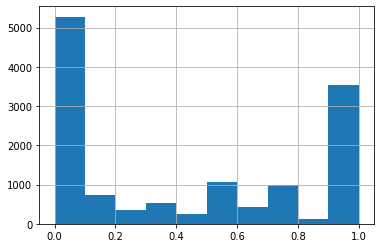

In [12]:
df[pd.notna(df["da_trend_p"])]["da_trend_p"].hist()

[Text(0, 0, 'Mountains, snow and ice'),
 Text(1, 0, 'Rivers, lakes, and soil moisture'),
 Text(2, 0, 'Coastal and marine Ecosystems'),
 Text(3, 0, 'Terrestrial ES'),
 Text(4, 0, 'Human and managed')]

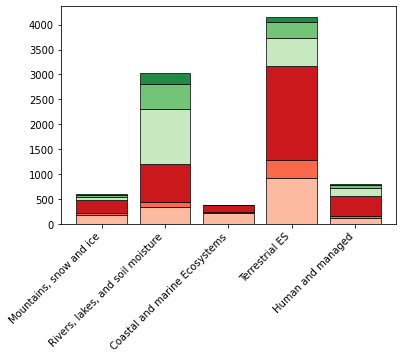

In [13]:
fig, ax = plt.subplots()

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.7

for i, col in enumerate(sector_cols):
    
    b = 0
    for j, da_var in enumerate(["Temperature","Precipitation"]):
        
        cm = mpl.cm.get_cmap(colors[j])
        
        cdf = df[(df[col]>0.5) & (df["da_var"]==da_var)]

        y = cdf[cdf['da_trend_p']==0].shape[0]
        ax.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
        b+=y

        y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
        ax.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
        b+=y

        y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
        ax.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
        b+=y
    
ticks, ticklabels = zip(*[(i, x.split(' - ')[1]) for i, x in enumerate(sector_cols)])
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha="right")

In [14]:
places = pd.read_csv('../data/place_df.csv')

import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class,continent
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.76,-98.5,PCLI,6252001,United States,A,North America
1,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.00,79.0,PCLI,1269750,Republic of India,A,Asia
2,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.00,100.0,PCLI,2017370,Russian Federation,A,Europe
3,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,30.00,70.0,PCLI,1168579,Islamic Republic of Pakistan,A,Asia
4,8,Cameroon,"[{'start': 213, 'end': 221}]",CMR,0.999931,"{'admin1': 'NA', 'lat': '6', 'lon': '12.5', 'c...",1336166,6.00,12.5,PCLI,2233387,Republic of Cameroon,A,Africa


(0.0, 1.0, 0.0, 1.0)

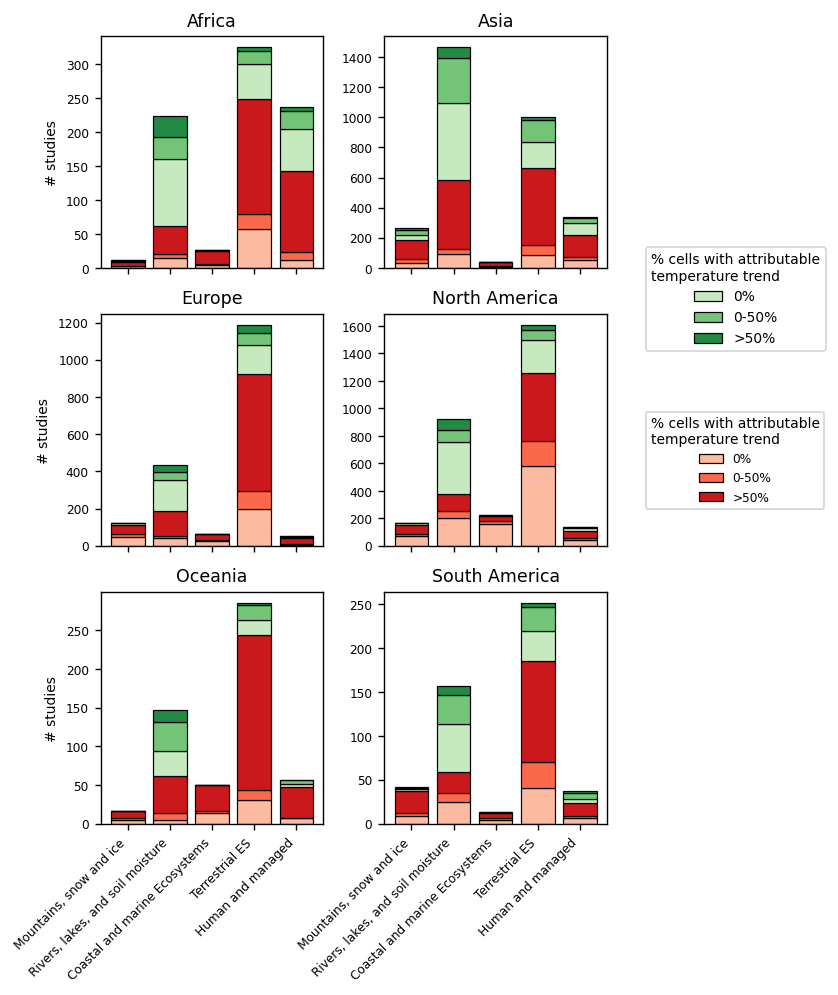

In [15]:

cols = 2

#fig, axs = plt.subplots(7//cols,cols, figsize=(7,7), dpi=125, sharex=True)

fig = plt.figure(figsize=(7,7), dpi=125)

gs = gridspec.GridSpec(6//cols, cols+1, width_ratios=[1]*cols+[0.5], bottom=.05, top=.95, wspace=.33)

ax = None



for ci, (continent, group) in enumerate(places.groupby('continent')):    
    
    #if ax is not None:    
    #ax = axs[ci//cols, ci%cols]
    
    ax = plt.subplot(gs[ci//cols, ci%cols])
    
    colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

    lw = 0.7
    
    vdf = df[df["id"].isin(group["doc_id"])]
    
    vdf.da_trend_p.mean()

    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = ax.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = ax.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = ax.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)

    ticks, ticklabels = zip(*[(i, x.split(' - ')[1]) for i, x in enumerate(sector_cols)])
    ax.set_xticks(ticks)
    if ci//cols+1 < 6//cols:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    ax.set_title(continent, fontsize=10)
    if ci%cols==0:
        ax.set_ylabel("# studies", fontsize=8)
        
    ax.tick_params(axis='both', which='major', labelsize=7)
        
        
attrib_labels = [
    "0%",
    "0-50%",
    ">50%"
]
    
    
ax = plt.subplot(gs[:, 2])
l0 = ax.legend(
    all_handles[0], attrib_labels, 
    loc=(-0.2,0.4),
    fontsize=7
)    
l0.set_title("% cells with attributable\ntemperature trend", prop={'size':8})
l1 = ax.legend(
    all_handles[1], 
    attrib_labels, 
    loc=(-0.2,0.6),
    fontsize=8
)
l1.set_title("% cells with attributable\ntemperature trend", prop={'size':8})
plt.gca().add_artist(l0)
ax.axis("off")
